In [ ]:
from accelerate import Accelerator
import os 
import numpy as np
import torch
from models.mae_with_hemisphere_embed_and_diff_dim_per_area import MAE_with_region_stitcher
from utils.config_utils import config_from_kwargs, update_config
from utils.utils import set_seed, move_batch_to_device
from loader.data_loader_ibl import *
from utils.mask import get_force_mask
from utils.metric_utils import Poisson_fraction_deviance_explained, get_deviance_explained
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.cluster import KMeans
from tqdm import tqdm

In [3]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'DejaVu Sans'
figure_path = '/work/hdd/bdye/jxia4/results/figures/'

In [4]:
session_order_file = "/work/hdd/bdye/jxia4/data/tables_and_infos/ibl_eids.txt"

with open(session_order_file, 'r') as file:
    eids = [line.strip() for line in file]

# Print loaded eids for debugging
print(f"Loaded eids: {eids}")

Loaded eids: ['f312aaec-3b6f-44b3-86b4-3a0c119c0438', '51e53aff-1d5d-4182-a684-aba783d50ae5', '88224abb-5746-431f-9c17-17d7ef806e6a', 'c7248e09-8c0d-40f2-9eb4-700a8973d8c8', '4b00df29-3769-43be-bb40-128b1cba6d35', 'a8a8af78-16de-4841-ab07-fde4b5281a03', 'ebe090af-5922-4fcd-8fc6-17b8ba7bad6d', '6c6b0d06-6039-4525-a74b-58cfaa1d3a60', 'dc962048-89bb-4e6a-96a9-b062a2be1426', '0841d188-8ef2-4f20-9828-76a94d5343a4', '3e6a97d3-3991-49e2-b346-6948cb4580fb', '9b528ad0-4599-4a55-9148-96cc1d93fb24', 'e2b845a1-e313-4a08-bc61-a5f662ed295e', '2bdf206a-820f-402f-920a-9e86cd5388a4', 'ecb5520d-1358-434c-95ec-93687ecd1396', '4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b', '15b69921-d471-4ded-8814-2adad954bcd8', '49e0ab27-827a-4c91-bcaa-97eea27a1b8d', '7f6b86f9-879a-4ea2-8531-294a221af5d0', '4fa70097-8101-4f10-b585-db39429c5ed0']


In [5]:
base_path = '/work/hdd/bdye/jxia4/results/mae_results'
num_train_sessions = len(eids)

mask_mode = 'region'

region_channel_num_encoder = 48 # number of region channels in encoder
unit_embed_dim = 50
n_layers = 5
consistency = True

num_epochs = 1000
batch_size = 16
use_wandb = False

kwargs = {
    "model": f"include:/work/hdd/bdye/jxia4/code/autoencoder_mae/src/configs/mae_with_hemisphere_embed_and_diff_dim_per_area_ibl.yaml",
}

config = config_from_kwargs(kwargs)
config = update_config("/work/hdd/bdye/jxia4/code/autoencoder_mae/src/configs/finetune_sessions_trainer.yaml", config)

config['model']['encoder']['masker']['mask_mode'] = mask_mode
config['model']['encoder']['stitcher']['n_channels_per_region'] = region_channel_num_encoder
config['model']['encoder']['stitcher']['unit_embed_dim'] = unit_embed_dim
config['training']['num_epochs'] = num_epochs
config['wandb']['use'] = use_wandb

meta_data = {}

dataloader, num_neurons, datasets, areaoi_ind, area_ind_list_list, heldout_info_list, trial_type_dict = make_loader(eids, batch_size, seed=config.seed)
set_seed(config.seed) 

  0%|          | 0/20 [00:00<?, ?it/s]

f312aaec-3b6f-44b3-86b4-3a0c119c0438
EID f312aaec-3b6f-44b3-86b4-3a0c119c0438
Loading EID f312aaec-3b6f-44b3-86b4-3a0c119c0438 from cached data
Brain region summary: 
{'PO': 174, 'LP': 206, 'DG': 123, 'CA1': 234, 'VISa': 314, 'VPM': 0, 'APN': 172, 'MRN': 56}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18}
Spike data shape:  (1504, 200, 533)
Spike data shape after removing unrecorded areas:  (1298, 200, 533)


  5%|▌         | 1/20 [00:03<01:15,  3.97s/it]

51e53aff-1d5d-4182-a684-aba783d50ae5
EID 51e53aff-1d5d-4182-a684-aba783d50ae5
Loading EID 51e53aff-1d5d-4182-a684-aba783d50ae5 from cached data
Brain region summary: 
{'PO': 217, 'LP': 102, 'DG': 88, 'CA1': 90, 'VISa': 74, 'VPM': 28, 'APN': 143, 'MRN': 0}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29}
Spike data shape:  (1189, 200, 321)
Spike data shape after removing unrecorded areas:  (1115, 200, 321)


 10%|█         | 2/20 [00:06<00:51,  2.84s/it]

88224abb-5746-431f-9c17-17d7ef806e6a
EID 88224abb-5746-431f-9c17-17d7ef806e6a
Loading EID 88224abb-5746-431f-9c17-17d7ef806e6a from cached data
Brain region summary: 
{'PO': 303, 'LP': 57, 'DG': 76, 'CA1': 84, 'VISa': 2, 'VPM': 0, 'APN': 0, 'MRN': 2}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts'): 

 15%|█▌        | 3/20 [00:08<00:42,  2.51s/it]

c7248e09-8c0d-40f2-9eb4-700a8973d8c8
EID c7248e09-8c0d-40f2-9eb4-700a8973d8c8
Loading EID c7248e09-8c0d-40f2-9eb4-700a8973d8c8 from cached data
Brain region summary: 
{'PO': 257, 'LP': 152, 'DG': 8, 'CA1': 82, 'VISa': 245, 'VPM': 35, 'APN': 0, 'MRN': 0}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts'

 20%|██        | 4/20 [00:10<00:42,  2.63s/it]

4b00df29-3769-43be-bb40-128b1cba6d35
EID 4b00df29-3769-43be-bb40-128b1cba6d35
Loading EID 4b00df29-3769-43be-bb40-128b1cba6d35 from cached data
Brain region summary: 
{'PO': 62, 'LP': 118, 'DG': 113, 'CA1': 56, 'VISa': 5, 'VPM': 122, 'APN': 0, 'MRN': 0}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts'

 25%|██▌       | 5/20 [00:13<00:40,  2.70s/it]

a8a8af78-16de-4841-ab07-fde4b5281a03
EID a8a8af78-16de-4841-ab07-fde4b5281a03
Loading EID a8a8af78-16de-4841-ab07-fde4b5281a03 from cached data
Brain region summary: 
{'PO': 10, 'LP': 281, 'DG': 351, 'CA1': 340, 'VISa': 93, 'VPM': 43, 'APN': 0, 'MRN': 0}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts

 30%|███       | 6/20 [00:17<00:43,  3.10s/it]

ebe090af-5922-4fcd-8fc6-17b8ba7bad6d
EID ebe090af-5922-4fcd-8fc6-17b8ba7bad6d
Loading EID ebe090af-5922-4fcd-8fc6-17b8ba7bad6d from cached data
Brain region summary: 
{'PO': 103, 'LP': 152, 'DG': 113, 'CA1': 132, 'VISa': 121, 'VPM': 495, 'APN': 0, 'MRN': 0}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tra

 35%|███▌      | 7/20 [00:23<00:51,  3.96s/it]

6c6b0d06-6039-4525-a74b-58cfaa1d3a60
EID 6c6b0d06-6039-4525-a74b-58cfaa1d3a60
Loading EID 6c6b0d06-6039-4525-a74b-58cfaa1d3a60 from cached data
Brain region summary: 
{'PO': 0, 'LP': 8, 'DG': 275, 'CA1': 226, 'VISa': 208, 'VPM': 0, 'APN': 428, 'MRN': 225}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tract

 40%|████      | 8/20 [00:29<00:54,  4.54s/it]

dc962048-89bb-4e6a-96a9-b062a2be1426
EID dc962048-89bb-4e6a-96a9-b062a2be1426
Loading EID dc962048-89bb-4e6a-96a9-b062a2be1426 from cached data
Brain region summary: 
{'PO': 0, 'LP': 73, 'DG': 163, 'CA1': 215, 'VISa': 218, 'VPM': 0, 'APN': 349, 'MRN': 155}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber trac

 45%|████▌     | 9/20 [00:31<00:40,  3.71s/it]

0841d188-8ef2-4f20-9828-76a94d5343a4
EID 0841d188-8ef2-4f20-9828-76a94d5343a4
Loading EID 0841d188-8ef2-4f20-9828-76a94d5343a4 from cached data
Brain region summary: 
{'PO': 0, 'LP': 94, 'DG': 291, 'CA1': 257, 'VISa': 156, 'VPM': 0, 'APN': 416, 'MRN': 104}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber trac

 50%|█████     | 10/20 [00:33<00:32,  3.28s/it]

3e6a97d3-3991-49e2-b346-6948cb4580fb
EID 3e6a97d3-3991-49e2-b346-6948cb4580fb
Loading EID 3e6a97d3-3991-49e2-b346-6948cb4580fb from cached data
Brain region summary: 
{'PO': 0, 'LP': 1, 'DG': 220, 'CA1': 329, 'VISa': 167, 'VPM': 0, 'APN': 454, 'MRN': 69}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts

 55%|█████▌    | 11/20 [00:37<00:30,  3.42s/it]

9b528ad0-4599-4a55-9148-96cc1d93fb24
EID 9b528ad0-4599-4a55-9148-96cc1d93fb24
Loading EID 9b528ad0-4599-4a55-9148-96cc1d93fb24 from cached data
Brain region summary: 
{'PO': 0, 'LP': 7, 'DG': 36, 'CA1': 159, 'VISa': 88, 'VPM': 0, 'APN': 166, 'MRN': 116}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts'

 60%|██████    | 12/20 [00:38<00:22,  2.83s/it]

e2b845a1-e313-4a08-bc61-a5f662ed295e
EID e2b845a1-e313-4a08-bc61-a5f662ed295e
Loading EID e2b845a1-e313-4a08-bc61-a5f662ed295e from cached data
Brain region summary: 
{'PO': 0, 'LP': 146, 'DG': 268, 'CA1': 452, 'VISa': 452, 'VPM': 0, 'APN': 469, 'MRN': 232}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tra

 65%|██████▌   | 13/20 [00:43<00:23,  3.32s/it]

2bdf206a-820f-402f-920a-9e86cd5388a4
EID 2bdf206a-820f-402f-920a-9e86cd5388a4
Loading EID 2bdf206a-820f-402f-920a-9e86cd5388a4 from cached data
Brain region summary: 
{'PO': 0, 'LP': 188, 'DG': 283, 'CA1': 317, 'VISa': 220, 'VPM': 0, 'APN': 305, 'MRN': 221}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tra

 70%|███████   | 14/20 [00:48<00:23,  3.89s/it]

ecb5520d-1358-434c-95ec-93687ecd1396
EID ecb5520d-1358-434c-95ec-93687ecd1396
Loading EID ecb5520d-1358-434c-95ec-93687ecd1396 from cached data
Brain region summary: 
{'PO': 0, 'LP': 8, 'DG': 304, 'CA1': 364, 'VISa': 441, 'VPM': 0, 'APN': 457, 'MRN': 68}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts

 75%|███████▌  | 15/20 [00:52<00:19,  3.87s/it]

4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b
EID 4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b
Loading EID 4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b from cached data
Brain region summary: 
{'PO': 0, 'LP': 32, 'DG': 95, 'CA1': 107, 'VISa': 210, 'VPM': 0, 'APN': 74, 'MRN': 98}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts'

 80%|████████  | 16/20 [00:57<00:17,  4.31s/it]

15b69921-d471-4ded-8814-2adad954bcd8
EID 15b69921-d471-4ded-8814-2adad954bcd8
Loading EID 15b69921-d471-4ded-8814-2adad954bcd8 from cached data
Brain region summary: 
{'PO': 156, 'LP': 82, 'DG': 288, 'CA1': 176, 'VISa': 206, 'VPM': 82, 'APN': 0, 'MRN': 0}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tract

 85%|████████▌ | 17/20 [01:01<00:12,  4.29s/it]

49e0ab27-827a-4c91-bcaa-97eea27a1b8d
EID 49e0ab27-827a-4c91-bcaa-97eea27a1b8d
Loading EID 49e0ab27-827a-4c91-bcaa-97eea27a1b8d from cached data
Brain region summary: 
{'PO': 0, 'LP': 0, 'DG': 56, 'CA1': 265, 'VISa': 0, 'VPM': 0, 'APN': 414, 'MRN': 80}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts'):

 90%|█████████ | 18/20 [01:08<00:09,  5.00s/it]

7f6b86f9-879a-4ea2-8531-294a221af5d0
EID 7f6b86f9-879a-4ea2-8531-294a221af5d0
Loading EID 7f6b86f9-879a-4ea2-8531-294a221af5d0 from cached data
Brain region summary: 
{'PO': 0, 'LP': 0, 'DG': 312, 'CA1': 575, 'VISa': 507, 'VPM': 0, 'APN': 541, 'MRN': 0}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts'

 95%|█████████▌| 19/20 [01:17<00:06,  6.38s/it]

4fa70097-8101-4f10-b585-db39429c5ed0
EID 4fa70097-8101-4f10-b585-db39429c5ed0
Loading EID 4fa70097-8101-4f10-b585-db39429c5ed0 from cached data
Brain region summary: 
{'PO': 18, 'LP': 7, 'DG': 0, 'CA1': 4, 'VISa': 0, 'VPM': 281, 'APN': 0, 'MRN': 0}
Updated region index dict:  {'PO': 0, 'LP': 1, 'DG': 2, 'CA1': 3, 'VISa': 4, 'VPM': 5, 'APN': 6, 'MRN': 7, np.str_('CA3'): 8, np.str_('HPF'): 9, np.str_('MB'): 10, np.str_('POL'): 11, np.str_('alv'): 12, np.str_('bsc'): 13, np.str_('ccs'): 14, np.str_('cing'): 15, np.str_('or'): 16, np.str_('root'): 17, np.str_('void'): 18, np.str_('COApm'): 19, np.str_('HATA'): 20, np.str_('NOT'): 21, np.str_('PA'): 22, np.str_('PIL'): 23, np.str_('PPT'): 24, np.str_('PoT'): 25, np.str_('SNc'): 26, np.str_('SNr'): 27, np.str_('cpd'): 28, np.str_('scwm'): 29, np.str_('HY'): 30, np.str_('LHA'): 31, np.str_('LM'): 32, np.str_('MH'): 33, np.str_('PF'): 34, np.str_('PRC'): 35, np.str_('SPFp'): 36, np.str_('TH'): 37, np.str_('V3'): 38, np.str_('fiber tracts'): 39

100%|██████████| 20/20 [01:19<00:00,  3.95s/it]

num_neurons:  [1073, 668, 444, 744, 358, 1108, 995, 1095, 824, 902, 1170, 565, 1751, 1229, 1201, 518, 784, 735, 1360, 299]
num_trials:  {'train': [319, 192, 252, 424, 398, 252, 499, 485, 194, 218, 297, 305, 237, 301, 241, 406, 444, 444, 492, 237], 'val': [107, 64, 84, 142, 133, 84, 167, 162, 65, 73, 99, 102, 79, 100, 80, 135, 148, 148, 164, 79], 'test': [107, 65, 84, 142, 133, 84, 167, 162, 65, 73, 100, 102, 79, 101, 81, 136, 149, 148, 165, 79]}
Succesfully constructing the dataloader for  train
Succesfully constructing the dataloader for  val
Succesfully constructing the dataloader for  test
seed set to 42


In [6]:
set_seed(config.seed)  

meta_data['area_ind_list_list'] = area_ind_list_list
meta_data['areaoi_ind'] = areaoi_ind
meta_data['num_sessions'] = len(eids)
meta_data['eids'] = [eid_idx for eid_idx, eid in enumerate(eids)]

#load pr_max_dict
pr_max_dict_path = '/work/hdd/bdye/jxia4/data/tables_and_infos/pr_max_dict_ibl.pkl'
with open(pr_max_dict_path, 'rb') as f:
    pr_max_dict = pickle.load(f)

for k, v in pr_max_dict.items():
    pr_max_dict[k] = int(v)

meta_data['pr_max_dict'] = pr_max_dict

trial_type_values = list(trial_type_dict.values())
meta_data['trial_type_values'] = trial_type_values

config = update_config(config, meta_data) # so that everything is saved in the config file

test_dataloader = dataloader['test']

seed set to 42


In [7]:
accelerator = Accelerator()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [8]:
print('start loading model...')
consistency = True
with_reg = True
num_train_sessions = 20

model_path = f'{base_path}/train/ibl_wo_trial_type_embed/with_reg_{with_reg}_2check/consistency_{consistency}/n_layers_{n_layers}/encoder_factors_{region_channel_num_encoder}/unit_embed_dim_{unit_embed_dim}/num_session_{num_train_sessions}/model_best_eval_loss.pt'
model = MAE_with_region_stitcher(config.model, **meta_data)

state_dict = torch.load(model_path)['model']
model.load_state_dict(state_dict)
model = accelerator.prepare(model)

model.eval()

start loading model...


/tmp/ipykernel_3458763/1728341679.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)['model']


MAE_with_region_stitcher(
  (encoder): NeuralEncoder(
    (stitchers): NeuralStitcher_cross_att(
      (unit_embed_dict): ModuleDict(
        (0): Embedding(1073, 50)
        (1): Embedding(668, 50)
        (2): Embedding(444, 50)
        (3): Embedding(744, 50)
        (4): Embedding(358, 50)
        (5): Embedding(1108, 50)
        (6): Embedding(995, 50)
        (7): Embedding(1095, 50)
        (8): Embedding(824, 50)
        (9): Embedding(902, 50)
        (10): Embedding(1170, 50)
        (11): Embedding(565, 50)
        (12): Embedding(1751, 50)
        (13): Embedding(1229, 50)
        (14): Embedding(1201, 50)
        (15): Embedding(518, 50)
        (16): Embedding(784, 50)
        (17): Embedding(735, 50)
        (18): Embedding(1360, 50)
        (19): Embedding(299, 50)
      )
      (dropout): Dropout(p=0.2, inplace=False)
      (region_embed): Embedding(8, 20)
      (hemisphere_embed): Embedding(2, 3)
      (key): Linear(in_features=273, out_features=512, bias=False)
     

In [9]:
areaoi_ind = np.array(areaoi_ind)

In [10]:
encoder_latent = {}
for eid_ind in range(len(eids)):
    encoder_latent[eid_ind] = {}

decoder_weights = {}
spike_data = {}
behavior_data = {}

set_seed(config.seed)
with torch.no_grad():
    for batch in test_dataloader:
        device = accelerator.device
        batch = move_batch_to_device(batch, device)
        B = batch['spikes_data'].size(0)
        T = batch['spikes_data'].size(1)
        eid = batch['eid'][0].item()
        print('eid', eid)
        neuron_regions = batch['neuron_regions'][0] #(N,) area_ind_list
        area_ind_unique_tensor = neuron_regions.unique()
        R = len(area_ind_unique_tensor) #number of regions

        #don't mask any data
        mask_T = torch.zeros([B,T], dtype=torch.bool, device=device)
        mask_R = torch.zeros([B,R], dtype=torch.bool, device=device)
        ids_restore_R = None
        ids_restore_T = None
        mask = torch.zeros([B,T,R], dtype=torch.bool, device=device)

        force_mask ={'mask': mask, 
                    'mask_R': mask_R, 
                    'mask_T': mask_T, 
                    'ids_restore_R': ids_restore_R, 
                    'ids_restore_T': ids_restore_T}

        area_ind_list_full = batch['neuron_regions_full'][0] # (N_all,) 

        x, mask, mask_R, mask_T, ids_restore_R, ids_restore_T = model.encoder(batch['spikes_data'], 
                                                                            batch['spikes_timestamps'],
                                                                            area_ind_unique_tensor, 
                                                                            batch['neuron_regions'],
                                                                            batch['is_left'],
                                                                            batch['trial_type'], 
                                                                            mask_mode, 
                                                                            batch['eid'][0], 
                                                                            force_mask)
        
        # Decode
        factors_pred_dict = {}
        for area_ind in areaoi_ind:
            x_tmp = x[:,:, areaoi_ind==area_ind,:].squeeze(dim=2) # (B, T, H)
            factors_pred_dict[str(area_ind)] = model.stitch_decoder.linear_layer_dict[str(area_ind)](x_tmp).detach().cpu().numpy() # (B, T, n_channels_this_region)

        trial_type = batch['trial_type']

        eid_ind = eid
        heldout_area_ind = heldout_info_list[eid_ind]['heldout_region_ind']
        encoder_latent[eid]['heldout_spikes'] = batch['spikes_data_full'][:,:,area_ind_list_full==heldout_area_ind].detach().cpu().numpy()
        
        encoder_latent[eid]['factors_pred'] = factors_pred_dict 
        encoder_latent[eid]['trial_type'] = trial_type.detach().cpu().numpy()
        encoder_latent[eid]['area_ind_unique'] = area_ind_unique_tensor.detach().cpu().numpy()
        encoder_latent[eid]['num_neurons'] = {}
        for area_ind in area_ind_unique_tensor:
            encoder_latent[eid]['num_neurons'][str(area_ind.item())] = (neuron_regions==area_ind).sum().item()

        decoder_weights[eid] = {}
        spike_data[eid] = {}
        for area_ind in area_ind_unique_tensor:
            decoder_weights[eid][str(area_ind.item())] = model.stitch_decoder.stitch_decoder_dict[str(eid)][str(area_ind.item())]
            spike_data[eid][str(area_ind.item())] = batch['spikes_data'][:,:,neuron_regions==area_ind].detach().cpu().numpy() # (B, T, # of neurons in this area)
        
        behavior_data[eid] = batch['target'].detach().cpu().numpy()
        # x = model.encoder.stitchers(batch['spikes_data'], str(batch['eid'][0].item()), batch['neuron_regions']) # (B, T, R, n_channels)
        # encoder_latent[eid]['embed_factor'] = {}
        # for id, area_ind in enumerate(area_ind_unique_tensor):
        #     encoder_latent[eid]['embed_factor'][str(area_ind.item())] = x[:,:,id,:].detach().cpu().numpy()

        


seed set to 42
eid 0
eid 17
eid 15
eid 1
eid 8
eid 5
eid 11
eid 3
eid 18
eid 16
eid 13
eid 2
eid 9
eid 19
eid 4
eid 12
eid 7
eid 10
eid 14
eid 6


In [11]:
brain_region_list = ["PO", "LP", "DG", "CA1", "VISa", "VPM", "APN", "MRN"]

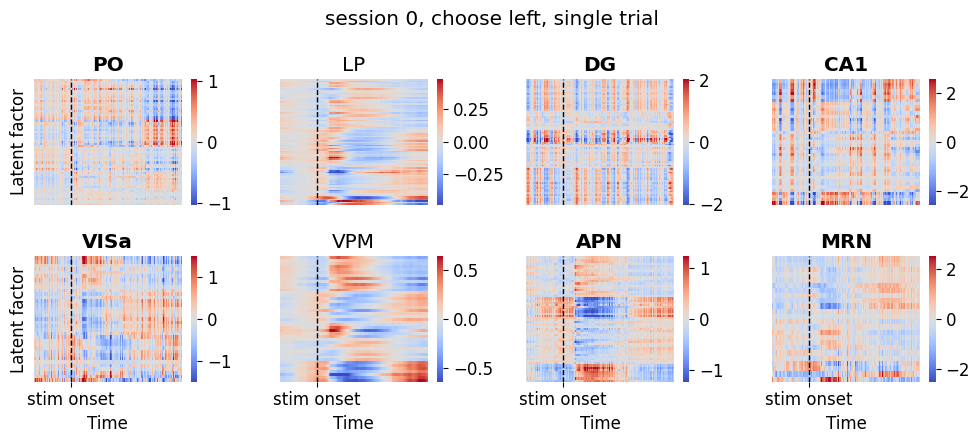

In [12]:
n_row = 2
n_col = 4

fig, ax = plt.subplots(n_row, n_col, figsize=(10, 4.5))
trial_type_key = 'left'
trial_type_ind = trial_type_dict[trial_type_key]
eid = 0
plt.suptitle(f'session {eid}, choose {trial_type_key}, single trial')
trial_type = encoder_latent[eid]['trial_type']

if not trial_type_ind in trial_type:
    print('trial type not in session')
    exit()

trial_ind = np.where(trial_type == trial_type_ind)[0][0]

if 'factor_order_dict' not in globals():
    factor_order_dict = {}

for i in range(n_row):
    for j in range(n_col):
        plt.sca(ax[i,j])

        area_ind = areaoi_ind[i*n_col + j]
        factors_pred_region = encoder_latent[eid]['factors_pred'][str(area_ind)]
        factors_pred_region_tmp = factors_pred_region[trial_ind] - np.mean(factors_pred_region[trial_ind][:], axis=0, keepdims=True)

        if (area_ind not in factor_order_dict) and (trial_type_key == 'left'):
            kmeans = KMeans(n_clusters=5, random_state=0).fit(factors_pred_region_tmp.T)
            factor_order = np.argsort(kmeans.labels_)
            factor_order_dict[area_ind] = factor_order

        vmax = np.quantile(factors_pred_region_tmp[:,factor_order_dict[area_ind]][:], 0.999)
        #vmin = np.quantile(factors_pred_region_tmp[:,factor_order_dict[area_ind]][:])

        sns.heatmap(factors_pred_region_tmp[:,factor_order_dict[area_ind]].T, cmap='coolwarm', vmax=vmax, vmin=-vmax)

        plt.axvline(x=50, color='k', linestyle='--', linewidth=1)

        if i == n_row-1:
            plt.xlabel('Time')
            plt.xticks([50], ['stim onset'], rotation=0)
        else:
            plt.xticks([])
        if j == 0:
            plt.ylabel('Latent factor')
        
        area_ind_unique = encoder_latent[eid]['area_ind_unique']
        if area_ind in area_ind_unique:
            ax[i,j].set_title(f'{brain_region_list[area_ind]}', fontweight='bold')
        else:
            ax[i,j].set_title(f'{brain_region_list[area_ind]}')
        
        ax[i,j].set_yticks([])


plt.tight_layout()
#plt.savefig(f'{figure_path}/fig4_IBL/ibl_factor_each_areas_single_trial_{eid}_{trial_type_key}.pdf', transparent=True)

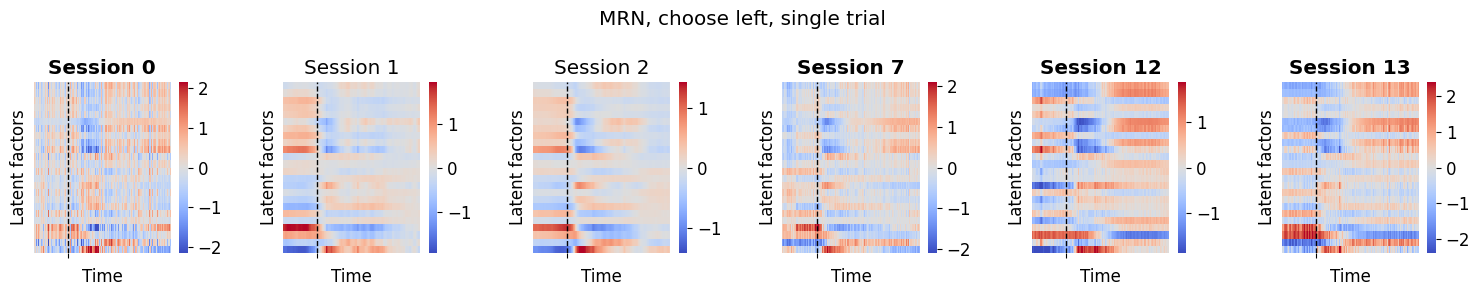

In [13]:
# plot inferred factors in ALM across sessions
area_ind = areaoi_ind[-1]
n_row = 1
n_col = 6
fig, ax = plt.subplots(n_row, n_col, figsize=(15, 3))
trial_type_key = 'left'
trial_type_ind = trial_type_dict[trial_type_key]

factor_order = factor_order_dict[area_ind] 
eid_ind_list = np.arange(num_train_sessions)

for i in range(n_row):
    for j in range(n_col):
        if i*n_col + j >= num_train_sessions:

            plt.sca(ax[j])
            plt.axis('off')

            break
        eid = eid_ind_list[[0,1,2,7,12,13]][i*n_col + j]
        factors_pred_region = encoder_latent[eid]['factors_pred'][str(area_ind)]
        trial_type = encoder_latent[eid]['trial_type']

        if not trial_type_ind in trial_type:
            continue

        trial_ind = np.where(trial_type == trial_type_ind)[0][-1]
        #print(trial_ind)
        plt.sca(ax[j])

        factors_pred_region_tmp = factors_pred_region[trial_ind] - np.mean(factors_pred_region[trial_ind][:], axis=0, keepdims=True)

        vmax = np.quantile(factors_pred_region_tmp[:,factor_order_dict[area_ind]][:], 0.999)
        vmin = np.min(factors_pred_region_tmp[:,factor_order_dict[area_ind]][:])

        sns.heatmap(factors_pred_region_tmp[:,factor_order].T, cmap='coolwarm', vmax=vmax, vmin=-vmax)
        plt.xlabel('Time')
        plt.ylabel('Latent factors')

        area_ind_unique = encoder_latent[eid]['area_ind_unique']
        if area_ind in area_ind_unique:
            ax[j].set_title('Session %d'%(eid), fontweight='bold')
        else:
            ax[j].set_title('Session %d'%(eid))

        ax[j].set_xticks([50])
        ax[j].set_yticks([])

        plt.axvline(50, color='black', lw=1, ls='--')

plt.suptitle(f'{brain_region_list[area_ind]}, choose {trial_type_key}, single trial')
plt.tight_layout()
#plt.savefig(figure_path+f'fig4_IBL/ibl_{brain_region_list[area_ind]}_{trial_type_key}_single_trial_across_session.pdf', transparent=True)


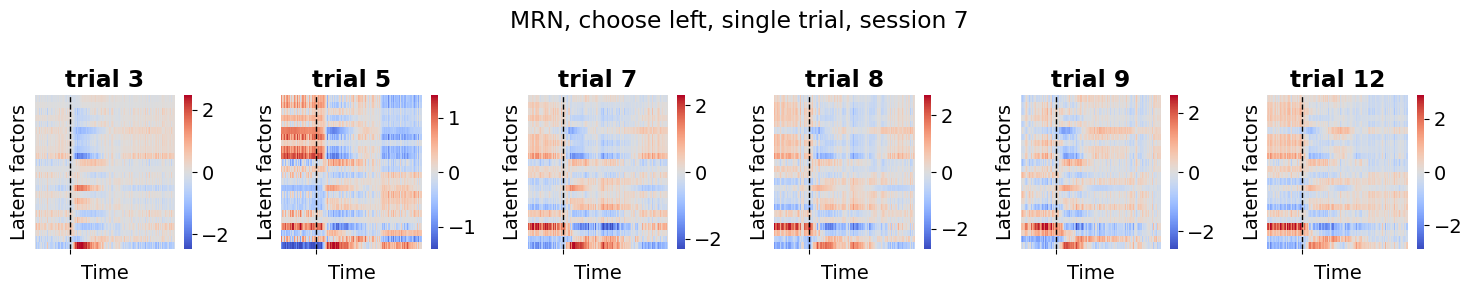

In [137]:
# plot inferred factors in ALM across trials
area_ind = areaoi_ind[-1]
n_row = 1
n_col = 6
fig, ax = plt.subplots(n_row, n_col, figsize=(15, 3))
trial_type_key = 'left'
trial_type_ind = trial_type_dict[trial_type_key]

eid_ind = 7

factor_order = factor_order_dict[area_ind] 

eid = eid_ind
factors_pred_region = encoder_latent[eid]['factors_pred'][str(area_ind)]
trial_type = encoder_latent[eid]['trial_type']
trial_ind_list = np.where(trial_type == trial_type_ind)[0]

trial_ind_left = np.where(trial_type == -1)[0]
trial_ind_right = np.where(trial_type == 1)[0]
trial_ind_hit = np.concatenate([trial_ind_left, trial_ind_right])

tmp_trial_avg = np.mean(factors_pred_region[trial_ind_hit], axis=0) 

for i in range(n_row):
    for j in range(n_col):
        if i*n_col + j >= len(trial_ind_list):
            break

        if not trial_type_ind in trial_type:
            continue

        trial_ind = trial_ind_list[i*n_col+j]
        #print(trial_ind)
        plt.sca(ax[j])

        #tmp1 = factors_pred_region[trial_ind]- tmp_trial_avg
        #factors_pred_region_tmp = tmp1 - np.mean(tmp1, axis=0, keepdims=True)
        factors_pred_region_tmp = factors_pred_region[trial_ind] - np.mean(factors_pred_region[trial_ind][:], axis=0, keepdims=True)

        vmax = np.quantile(factors_pred_region_tmp,0.999)
        #vmin = np.min(factors_pred_region_tmp)

        sns.heatmap(factors_pred_region_tmp[:,factor_order].T, cmap='coolwarm', vmax=vmax, vmin=-vmax)
        plt.xlabel('Time')
        plt.ylabel('Latent factors')

        area_ind_unique = encoder_latent[eid]['area_ind_unique']
        if area_ind in area_ind_unique:
            ax[j].set_title('trial %d'%(trial_ind), fontweight='bold')
        else:
            ax[j].set_title('trial %d'%(trial_ind))

        ax[j].set_yticks([])

        plt.axvline(50, color='black', lw=1, ls='--')
        ax[j].set_xticks([50])


plt.suptitle(f'{brain_region_list[area_ind]}, choose {trial_type_key}, single trial, session {eid_ind}')
plt.tight_layout()

#plt.savefig(figure_path+f'fig4_IBL/ibl_{brain_region_list[area_ind]}_{trial_type_key}_single_trial_across_trials_session_{eid}.pdf', transparent=True)
#plt.savefig(figure_path+f'fig4_IBL/ibl_{brain_region_list[area_ind]}_{trial_type_key}_single_trial_across_trials_session_{eid}_trial_avg_subtracted.pdf', transparent=True)

## RSA analysis

In [81]:
from scipy.stats import spearmanr

#calculate RSA between behavior data and latent factors from each area. 

def calculate_RSA(x_list):
    '''
    calculate representation distance matrix

    x_list: a list of (T, n_factors), with n elements or an array of (n, T, n_factors)
    return RSA: n x n

    '''

    n = len(x_list)
    rdm_list = []
    for i in range(n):    
       rdm_list.append(1-np.corrcoef(x_list[i]))
    
    rsa = np.zeros([n, n])*np.nan
    for i in range(n):
        for j in range(i+1,n):
            tmp_i = rdm_list[i][np.triu_indices(rdm_list[i].shape[0], k=1)]
            tmp_j = rdm_list[j][np.triu_indices(rdm_list[j].shape[0], k=1)]

            rsa[i,j] = spearmanr(tmp_i, tmp_j).correlation

    return rsa



In [82]:
rsa_dict = {}

In [111]:
trial_type_key = 'left'
trial_type_ind = trial_type_dict[trial_type_key]

rsa_dict[trial_type_key] = {}

for eid in tqdm(np.arange(num_train_sessions)):
    trial_type = encoder_latent[eid]['trial_type']

    if not trial_type_ind in trial_type:
        print('trial type not in session')
        exit()

    trial_ind_list = np.where(trial_type == trial_type_ind)[0]
    n_trials = len(trial_ind_list)
    #rsa_list = np.zeros([n_trials, len(areaoi_ind)+1, len(areaoi_ind)+1])*np.nan
    rsa_list = np.zeros([n_trials, len(areaoi_ind), len(areaoi_ind)])*np.nan

    for ind, trial_ind in enumerate(trial_ind_list):
        x_list = []

        for area_ind in areaoi_ind:
            factors_pred_region = encoder_latent[eid]['factors_pred'][str(area_ind)][trial_ind,:,:]
            factors_pred_region = factors_pred_region - np.mean(factors_pred_region[:], axis=0, keepdims=True)
            x_list.append(factors_pred_region[100:150])

        #behavior_data_tmp = behavior_data[eid][trial_ind,:,:]
        #behavior_data_tmp = behavior_data_tmp - np.mean(behavior_data_tmp, axis=0, keepdims=True)
        #x_list.append(behavior_data_tmp[50:115])

        rsa = calculate_RSA(x_list)
        rsa_list[ind] = rsa

    rsa_dict[trial_type_key][eid] = rsa_list


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


/tmp/ipykernel_1657408/2992691529.py:5: RuntimeWarning: Mean of empty slice
  rsa_trial_avg = np.nanmean(rsa_dict[trial_type_key][eid], axis=0)
/tmp/ipykernel_1657408/2992691529.py:9: RuntimeWarning: Mean of empty slice
  rsa_session_mean = np.nanmean(rsa_session_list, axis=0)
/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


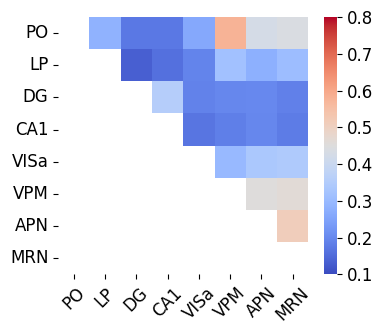

In [ ]:
trial_type_key = 'left'

rsa_session_list = []
for eid in np.arange(num_train_sessions):
    rsa_trial_avg = np.nanmean(rsa_dict[trial_type_key][eid], axis=0)
    rsa_session_list.append(rsa_trial_avg)

rsa_session_list = np.array(rsa_session_list)
rsa_session_mean = np.nanmean(rsa_session_list, axis=0)
rsa_session_std = np.nanstd(rsa_session_list, axis=0)

plt.figure(figsize=(4, 3.5))
#plt.subplot(121)
sns.heatmap(rsa_session_mean,cmap='coolwarm', vmax=0.8, vmin=0.1)

plt.xticks(np.arange(len(areaoi_ind))+0.5, brain_region_list[areaoi_ind], rotation=45)
plt.yticks(np.arange(len(areaoi_ind))+0.5, brain_region_list[areaoi_ind], rotation=0)
plt.tight_layout()

#plt.savefig(figure_path + f'fig4_IBL/ibl_RSA_across_areas_session_avg_{trial_type_key}_1_1p5.pdf', transparent=True)
